In [1]:
# !pip install qiskit
# !pip install pylatexenc
# !pip install qiskit_ibm_runtime

In [1]:
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account(token='081573a72593a0b5c2ffb1bfa2128ac29452fee91b33f7cf134b4c9b49353d495322f295acbc04200e3be4124025261972d3c8568d7d086e67178403d0ee110b', overwrite=True)

In [2]:
from qiskit_ibm_runtime import Session, Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, transpile
import numpy as np

provider = IBMProvider()
# backend = provider.get_backend("ibmq_manila")

In [7]:
backend.properties()
backend.configuration()

NameError: name 'backend' is not defined

In [13]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

def Customize_EfficientSU2(number_qubits, number_of_subcircuit):
    """
    number_qubits: The amounts of qubits in out system
    number_of_subcircuit: The amounts of subcuirt for parameterized our system
    su2gate: is the gate we want to parameterized with
    insert_barriers: add barriers in our circuit for nice looking
    The function will return the circuit having the parameter and we can update these parameter in our code
    """
    circuit = QuantumCircuit(number_qubits)


    # Use for the 1-qubit case
    if number_qubits == 1:
        theta1 = Parameter(r'$\theta[{}]$'.format(0))
        circuit.ry(theta1, 0)
        theta2 = Parameter(r'$\theta[{}]$'.format(1))
        circuit.rz(theta2, 0)
        circuit.barrier()

        for i in range(number_of_subcircuit):
            theta1 = Parameter(r'$\theta[{}]$'.format(2*i+2))
            circuit.ry(theta1, 0)
            theta2 = Parameter(r'$\theta[{}]$'.format(2*i+3))
            circuit.rz(theta2, 0)

            if i != number_of_subcircuit - 1:
                circuit.barrier()


        return circuit


    def add_subcircuit(circuit, stop_barrier):
        sub_circuit = QuantumCircuit(number_qubits)
        number_parameter = circuit.num_parameters

        sub_circuit.barrier()

        # sub_circuit.cx(number_qubits-1, 0)
        for i in (range(number_qubits-1)):
            sub_circuit.cx(i, i+1)

        # sub_circuit.cx(number_qubits-1, 0)

        sub_circuit.barrier()


        # hmm cause of lack of my knowledge, I will work with the RealAmplitudes ansat, circular entanglement
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_parameter+i))
            sub_circuit.ry(theta, i)
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_qubits+number_parameter+i))
            sub_circuit.rz(theta, i)


        # if stop_barrier != number_of_subcircuit-1:
        #     sub_circuit.barrier()

        # sub_circuit.draw('mpl', style = 'iqx')

        return sub_circuit


    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(i))
        circuit.ry(theta, i)

    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(number_qubits+i))
        circuit.rz(theta, i)

    for i in range(number_of_subcircuit):
        circuit = circuit.compose(add_subcircuit(circuit, i))

    return circuit


def Customize_RealAmplidues(number_qubits, number_of_subcircuit):
    """
    number_qubits: The amounts of qubits in out system
    number_of_subcircuit: The amounts of subcuirt for parameterized our system
    su2gate: is the gate we want to parameterized with
    insert_barriers: add barriers in our circuit for nice looking
    The function will return the circuit having the parameter and we can update these parameter in our code
    """
    circuit = QuantumCircuit(number_qubits)


    # Use for the 1-qubit case
    if number_qubits == 1:

        for i in range(0, number_qubits):
                theta = Parameter(r'$\theta[{}]$'.format(i))
                circuit.ry(theta, i)
                circuit.barrier()
        for i in range(number_of_subcircuit):
            theta1 = Parameter(r'$\theta[{}]$'.format(1+i))
            circuit.ry(theta1, 0)
            if i != number_of_subcircuit - 1:
                circuit.barrier()


        return circuit


    def add_subcircuit(circuit, stop_barrier):
        sub_circuit = QuantumCircuit(number_qubits)
        number_parameter = circuit.num_parameters

        sub_circuit.barrier()

        # sub_circuit.cx(number_qubits-1, 0)
        for i in (range(number_qubits-1)):
            sub_circuit.cx(i, i+1)

        sub_circuit.barrier()


        # hmm cause of lack of my knowledge, I will work with the RealAmplitudes ansat, circular entanglement
        for i in range(0, number_qubits):
            theta = Parameter(r'$\theta[{}]$'.format(number_parameter+i))
            sub_circuit.ry(theta, i)


        # if stop_barrier != number_of_subcircuit-1:
        #     sub_circuit.barrier()

        # sub_circuit.draw('mpl', style = 'iqx')

        return sub_circuit


    for i in range(0, number_qubits):
        theta = Parameter(r'$\theta[{}]$'.format(i))
        circuit.ry(theta, i)

    # for i in range(0, number_qubits):
    #     theta = Parameter(r'$\theta[{}]$'.format(number_qubits+i))
    #     circuit.rz(theta, i)

    for i in range(number_of_subcircuit):
        circuit = circuit.compose(add_subcircuit(circuit, i))

    return circuit

In [14]:
from qiskit.opflow import Z, I, X
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
import time

# Parameter shift rule
def Customize_Parameter_Shift_Rule(operator, parameter, eta, ansatz, shots, backend, interation, estimator):
    """
    operator: The pauli operator
    parameter: the initial point that we will update until we end up with the desired point
    ansatz: the parameterized circuit that we want to update
    eta: learning rate
    """
    number_of_parameters = len(parameter)
    grad = np.zeros(number_of_parameters)


    for i in range(len(operator)):
        grad_func = np.zeros(number_of_parameters)
        for j in range(number_of_parameters):
            plus_parameter = parameter.copy()
            plus_parameter[j] += np.pi/2
            minus_parameter = parameter.copy()
            minus_parameter[j] -= np.pi/2
            plus_circuit = ansatz.bind_parameters({theta: plus_parameter[k] for k, theta in enumerate(ansatz.parameters)})
            minus_circuit = ansatz.bind_parameters({theta: minus_parameter[k] for k, theta in enumerate(ansatz.parameters)})
            # print(plus_circuit)
            # print(minus_circuit)
            grad_func[j] = (eta)*operator.coeffs.real[i]*(estimator.run(plus_circuit, operator.primitive._pauli_list[i], shots=shots).result().values[0] - estimator.run(minus_circuit, (operator.primitive._pauli_list[i]), shots=shots).result().values[0])/2
            
        grad = np.add(grad, grad_func)

    return np.array(grad)


def Customize_Variational_Quantum_EigenSolver(operator, optimize, interation, ansatz, eta, initial_point, shots, backend, estimator, callback):
    """
    operator: the pauli matrix
    interation: number of interations
    ansatz: the ansatz for perparing the parameterized circuit
    eta: learning rate
    initial_points: random sample of number uses at the beggining of running
    shots: number of shots
    backend: the backend
    """

    energy = []

    internal_initial_point = initial_point.copy()

    b = np.zeros(ansatz.num_parameters)

    for i in range(interation):
        print(f'{internal_initial_point} ---------')
        internal_anstaz = ansatz.bind_parameters({theta: internal_initial_point[k] for k, theta in enumerate(ansatz.parameters)})
        
        # print(internal_anstaz)
        # Measure the expectation of our hamiltonian
        # internal_energy = 0
        # for j in range(len(operator)):
        #     internal_energy += operator.coeffs.real[j] * Measurement(str(operator.primitive._pauli_list[j]), internal_anstaz, shots, backend)[0]
        #     print(internal_energy)
        internal_energy = estimator.run(internal_anstaz, operator, shots=shots).result().values[0]
            # print( operator.coeffs.real[j])
            # print(operator.primitive._pauli_list[j])
            # print(internal_energy)

            # measure = Measurement('X', internal_anstaz, 10000, backend=Aer.get_backend('qasm_simulator'))[0]*10
            # print(f'///{measure}///')

        # print(f'{internal_initial_point} hmm')

        energy.append(internal_energy)
        print(internal_energy)


        if callback is not None:
            callback(internal_initial_point, internal_energy)

        # Update the parameter points
        # if optimize == Customize_Quantum_Natural_Graident_Descent:
        #     super_circuit = Seperate_Circuit_Apart(ansatz)
        #     a = np.add(optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation, super_circuit), -0.9*b)
        #     # b = a.copy()
        #     internal_initial_point =  np.subtract(internal_initial_point,a)
        #     # print(internal_energy)

        #     continue

        a = optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation, estimator)
        # a = np.add(optimize(operator, internal_initial_point, eta, ansatz, shots, backend, interation), -0.9*b)
        # b = a.copy()
        internal_initial_point =  np.subtract(internal_initial_point,a)
        # print(f'a: {a}')

        # print(internal_energy)

    if callback is None:
        return energy


from qiskit.opflow import Z, I, X
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.opflow.primitive_ops.pauli_sum_op import PauliSumOp
import time

# Ising hamiltonian
def Ising_hamiltonian(num_qubits, h):
    hamiltonian = 0

    if num_qubits == 1:
        hamiltonian = Z + h*X
        return hamiltonian.reduce()

    if num_qubits == 2:
        hamiltonian = Z^Z
        hamiltonian += h*X^I
        hamiltonian += h*I^X
        return hamiltonian.reduce()



    hamiltonian += Z^(I^(num_qubits-2))^Z
    for i in range(num_qubits-1):
        hamiltonian += (I^(i))^(Z^Z)^(I^(num_qubits-2-i))

    for i in range(num_qubits):
        hamiltonian += h*((I^(i))^(X)^(I^(num_qubits-1-i)))

    return hamiltonian.reduce()

In [ ]:
hamiltonian = Ising_hamiltonian(1,2)
hamiltonian = I^hamiltonian
for i in range(30):
    hamiltonian = hamiltonian^I
hamiltonian = hamiltonian.reduce()
print(hamiltonian)

1.0 * IZIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
+ 2.0 * IXIIIIIIIIIIIIIIIIIIIIIIIIIIIIII


In [ ]:
len(str(hamiltonian.primitive._pauli_list[0]))

32

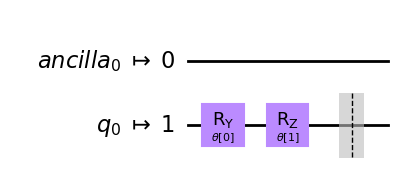

In [ ]:
q_layout = [1]
ansatz_opt = transpile(Customize_EfficientSU2(1, 0), backend=backend, initial_layout=q_layout)
ansatz_opt.draw('mpl')

In [11]:
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account(token='081573a72593a0b5c2ffb1bfa2128ac29452fee91b33f7cf134b4c9b49353d495322f295acbc04200e3be4124025261972d3c8568d7d086e67178403d0ee110b', overwrite=True)

In [18]:
from qiskit_ibm_runtime import Session, Estimator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, transpile
import numpy as np

provider = IBMProvider()
# backend = provider.get_backend("ibmq_qasm_simulator")

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_manila")

# backend = provider.get_backend("ibmq_qasm_simulator")


intermediate_info = {
    'parameters': [],
    'energy': [],
}

def callback(parameters, energy):
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)


with Session(backend=backend): #, max_time="8h"
    estimator = Estimator()

    #5.1 ansatz =
    q_layout = [0,1]
    ansatz_opt = transpile(Customize_RealAmplidues(2, 1), backend=backend, initial_layout=q_layout)
    # print(ansatz_opt)
    # ansatz_opt = transpile(Customize_EfficientSU2(1, 0), backend=backend)
    ansatz_opt.draw()

    interation = 4
    hamiltonian = Ising_hamiltonian(2,1)
    hamiltonian = (I^I^I^hamiltonian).reduce()

    eta = 0.2

    shots = 40000
    # hamiltonian = (hamiltonian^I^I^I^I).reduce()

#     initial_point = np.zeros(ansatz_opt.num_parameters)+0.5

    initial_point = np.array([ 0.32295148, -1.25155354, -1.87942447,  0.26938394])


    energy = Customize_Variational_Quantum_EigenSolver(hamiltonian, Customize_Parameter_Shift_Rule, interation, ansatz_opt, eta, initial_point, shots, backend, estimator, callback)


KeyError: 'qubits'

# Data print qubit = 1

h = 2

In [33]:
data_energy_2 = np.array([1.3548060637741766,  0.8352226831189289, 0.05292463157894739, -0.9466118827567996, -1.6377529225908374, -1.9839084988085784, -2.108073226061725, -2.162553740417658, -2.163384825413494,  -2.186553911205074,  -2.1743625164516978,  -2.161795737963694, -2.200257982525814, -2.218675766462277, -2.2043649906890135, -2.1850794666666666, -2.172288677248677])
data_params_2 = np.array([[1.5, 5.5], [1.60852133, 5.21317554], [1.78783398, 4.87320122], [2.03589668, 4.50423342], [2.26899689, 4.16976408], [2.42537399, 3.9270002 ], [2.50789535, 3.76696189], [2.54188364, 3.67034747], [2.5564608 , 3.61088714], [2.5624466 , 3.57010822], [2.5664041 , 3.54418947], [2.56598561, 3.52967624], [2.56300556, 3.51251868], [2.56433888, 3.51027463], [2.55896448, 3.50289008], [2.56223297, 3.4970556 ], [2.56254063, 3.50272364]])

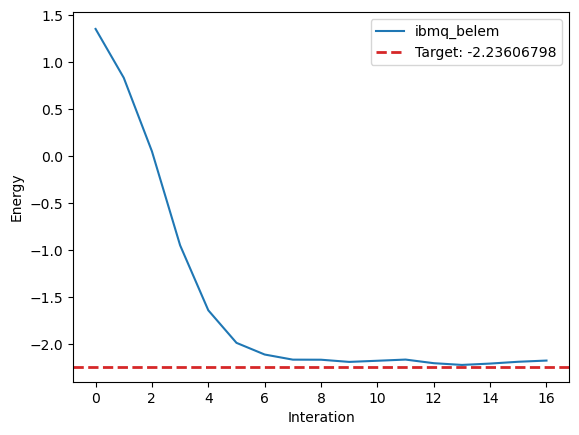

In [65]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gs_energy_2 = -2.23606798
plt.plot(data_energy, label='ibmq_belem')
plt.axhline(y=gs_energy_2, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_2))
plt.legend()
plt.xlabel('Interation')
plt.ylabel('Energy')
fig.savefig('PRS-1-h2-ibmq_belem.png', format='png', dpi=200)

h = 0

In [54]:
data_energy_0 = np.array([0.5227946103038309, 0.3780923076923077, 0.22761605955862801, 0.052241035120147876, -0.11838900924702773, -0.3148003192338388, -0.49598716920609465, -0.5964617094469437, -0.7041523406506216, -0.7839400052812252, -0.8469861133280128, -0.8682918436926305, -0.9024846113167636, -0.9240870116156283, -0.9353762711864406, -0.9493644314868805])
data_params_0 = np.array([[1.5, 5.5], [1.66086452, 5.49507745], [1.83595586, 5.48947694], [2.02396528, 5.48363602], [2.21693161, 5.47521907], [2.40738858, 5.46455654], [2.58796164, 5.45459571], [2.75661262, 5.446391  ], [2.75661262, 5.446391  ], [2.90609427, 5.43786614], [3.03575704, 5.42987967], [3.1462602 , 5.42431234], [3.23904893, 5.41781644], [3.31640605, 5.41223862], [3.37942131, 5.40812033], [3.42955213, 5.40348968], [3.47071807, 5.39902183]])

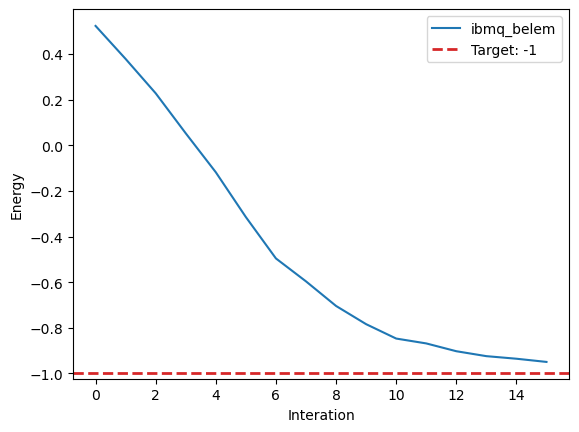

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gs_energy_0 = -1
plt.plot(data_energy_0, label='ibmq_belem')
plt.axhline(y=gs_energy_0, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_0))
plt.legend()
plt.xlabel('Interation')
plt.ylabel('Energy')
fig.savefig('PRS-1-h0-ibmq_belem.png', format='png', dpi=200)

h = 1

In [60]:
data_energy_1 = np.array([0.7527477297895904, 0.4473338157528527, 0.11901841304948851, -0.26307182320441985, -0.6022269675288938, -0.797540642303433, -0.9483192425508216, -1.0069945379310346, -1.0569810736026564, -1.0990650069156294, -1.1184185737976782, -1.1431039470052442, -1.16509947701624, -1.2180774869109947, -1.2318592531120331, -1.2593722530521643])
data_params_1 = np.array([[1.5, 5.5], [1.68321157, 5.35783537], [1.89141097, 5.20092438], [2.11257015, 5.03081209], [2.31775024, 4.86347753],[2.49195473, 4.71310024], [2.62024858, 4.58679532], [2.70596165, 4.48237407], [2.75693762, 4.39282378], [2.78075151, 4.31277913], [2.78591731, 4.24124748], [2.77892123, 4.17189271], [2.76441953, 4.10432856], [2.7403597, 4.0360944], [2.71459809, 3.9730618 ], [2.68414828, 3.90686672]])

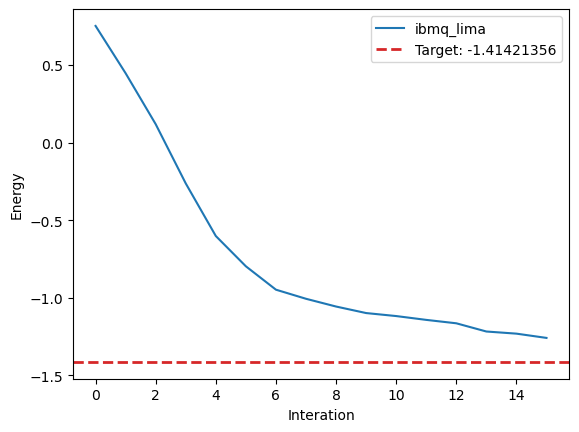

In [67]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gs_energy_1 = -1.41421356
plt.plot(data_energy_1, label='ibmq_lima')
plt.axhline(y=gs_energy_1, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_1))
plt.legend()
plt.xlabel('Interation')
plt.ylabel('Energy')
fig.savefig('PRS-1-h1-ibmq_lima.png', format='png', dpi=200)

h = 3

In [3]:
import numpy as np
data_energy_3 = np.array([2.166233950456323, 0.9832552956636005,-0.9100922917207371, -2.274116469038208, -2.874361586638831, -3.109313899010932, -3.1383436619718306, -3.1962176455096127, -3.176076943072524, -3.1869167544783985, -3.1410474655575773, -3.1874060822898027, -3.147916783398184, -3.1703811616954476, -3.1584806722689076, -3.1685836373110994])
data_params_3 = np.array([[1.5, 5.5], [1.67569279, 5.08149932], [1.91359098, 4.52503097], [2.06491969, 3.96925581], [2.05323938, 3.58864739], [1.97796581, 3.36790158], [1.92493436, 3.25202545], [1.89419995, 3.19016349], [1.89288596, 3.16860367], [1.89283529, 3.15697702], [1.89651893, 3.15337465], [1.88774032, 3.1500057 ], [1.87997116, 3.14765817], [1.88526257, 3.14764184], [1.88529172, 3.14598673], [1.89172839, 3.15058531]])

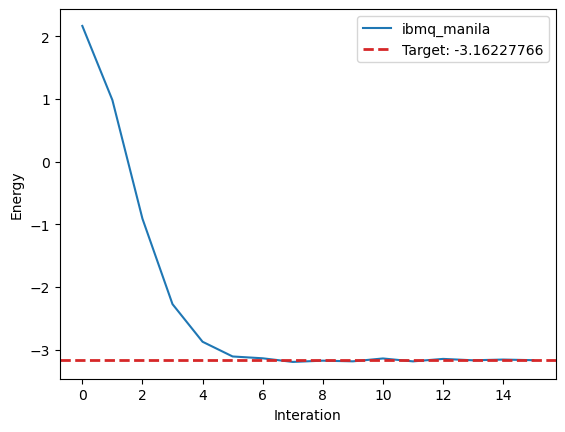

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gs_energy_3 = -3.16227766
plt.plot(data_energy_3, label='ibmq_manila')
plt.axhline(y=gs_energy_3, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_3))
plt.legend()
plt.xlabel('Interation')
plt.ylabel('Energy')
fig.savefig('PRS-1-h3-ibmq_lima.png', format='png', dpi=200)

# Data prin qubit = 2

h = 2.5

In [11]:
data_energy_25 = np.array([3.9384124875321915, 2.292082044633307, -1.441575904765788, -4.5353272321408165, -4.767662949833047, -4.86501599065214, -4.920169664474998, -4.953329331191216, -4.971887051662736, -4.954866485815606, -4.994165668175107, -5.00685793047503, -4.988189028711761, -4.967657290278807, -4.998976637356956, -4.977599186301551, -4.961951478492339, -4.968315728194105, -4.95601214067867, -4.993418129825193])
data_params_25 = np.array([[0.5, 0.5, 0.5, 0.5], [0.508481, 0.12938862, 0.20713412, 0.35928569], [0.59262208, -0.4925835, -0.19594132, 0.03656625], [0.73070974, -1.26096969, -0.58873023, -0.35621035], [0.71633611, -1.5077362, -0.65824258, -0.3146922], [0.72390379, -1.57544908, -0.68075827, -0.19071397], [0.74807393, -1.63653987, -0.69701689, -0.09862888], [0.76642114, -1.69241531, -0.7164972, -0.02158015], [0.77786969, -1.71735559, -0.72607103, 0.04432502], [0.78941901, -1.74400827, -0.73227784, 0.09030575], [0.79264334, -1.76804113, -0.73422145, 0.12512545], [0.79665652, -1.78518003, -0.73851142, 0.14748017], [0.79886289, -1.79495609, -0.74378548, 0.17103461], [0.79244587, -1.81083135, -0.74827397, 0.18631042], [0.79047612, -1.81258467, -0.75524059, 0.19913624], [0.78811919, -1.81728305, -0.76421797, 0.20294332], [0.78513106, -1.81669008, -0.77219032, 0.21086833], [0.78120616, -1.81954453, -0.77683282, 0.20972914], [0.7724806, -1.82711628, -0.78411554, 0.21398052], [0.7682467, -1.82933928, -0.79000361, 0.21716092]])

data_energy_simulator_25 = np.array([4.129975, 2.63835, -0.8673750000000001, -4.512275000000001, -4.80805, -4.8915500000000005, -4.9495249999999995, -4.9944749999999996, -5.0268, -5.042975, -5.058999999999999, -5.07335, -5.083, -5.0905249999999995, -5.0778, -5.093875000000001, -5.092874999999999, -5.104750000000001, -5.104675, -5.1015])

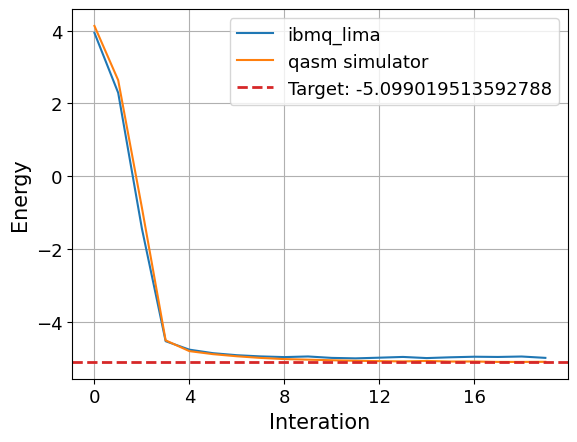

In [33]:
import matplotlib
import matplotlib.pyplot as plt
figure, ax = plt.subplots()
gs_energy_25 = -5.099019513592788
plt.plot(data_energy_25, label='ibmq_lima')
plt.plot(data_energy_simulator_25, label='qasm simulator')
plt.axhline(y=gs_energy_25, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_25))
plt.legend(fontsize=13)
plt.xlabel('Interation', fontsize=15)
plt.ylabel('Energy', fontsize=15)
size_tick = 13
plt.yticks(fontsize=size_tick)
plt.xticks([i for i in range(0,20, 4)], fontsize=size_tick)
plt.grid()
# figure.legend(loc='upper center' ,bbox_to_anchor=(0.5, 1.07),  ncol=2, fancybox=True, shadow=True, fontsize=15)
figure.savefig('PRS-2-h25-ibmq_lima.png', format='png', dpi=200)

h = 2

In [7]:
data_energy_2 = np.array([3.3095025005193905, 2.546268807734954, 0.6156749447001986, -2.364675034497395, -3.6683998233341057, -3.855535894985445, -3.900533386970167, -3.924211579424536, -3.997838745914497, -3.964989753211658, -4.013060405359363, -4.035486340594968, -4.024769592182322, -4.025714774516893, -4.02855797048309, -4.092484873991504, -4.034261478459245, -4.0430360066587125, -3.997672120458576, -4.065576349993986])
data_params_2 = np.array([[0.5, 0.5, 0.5, 0.5], [0.49808129, 0.23592405, 0.26968932, 0.40654939], [0.54540815, -0.18220414, -0.03395764, 0.20546524], [0.6513996, -0.78900164, -0.39071128, -0.11974379], [0.7189783, -1.3366042, -0.63200812, -0.35208263], [0.6915708, -1.51857586, -0.66821127, -0.308045], [0.69751834, -1.59525765, -0.68063441, -0.22021209], [0.71174274, -1.64722767, -0.69649381, -0.1428], [0.73038296, -1.68755347, -0.70969344, -0.06753622], [0.75058952, -1.73189544, -0.72104865, -0.00651241], [0.77140931, -1.7677938, -0.73125658, 0.04461771], [0.77957029, -1.78897837, -0.72880417, 0.09533695], [0.78952512, -1.81321804, -0.73202035, 0.13442522], [0.80018395, -1.83648008, -0.73304282, 0.15711315], [ 0.80549587, -1.84184482, -0.73065833,  0.1801717 ], [ 0.81077364, -1.84791641, -0.73643121,  0.19516089], [ 0.81010292, -1.85862742, -0.73847465,  0.20720933], [ 0.81367664, -1.86819068, -0.74154827,  0.22209325], [ 0.81076593, -1.87019336, -0.74956484,  0.23196325], [ 0.80972272, -1.87138171, -0.7543222,   0.23641606]])

data_energy_simulator_2 = np.array([3.4443, 2.66565, 0.9350499999999999, -1.9592999999999998, -3.70225, -3.86425, -3.9045500000000004, -3.9410000000000003, -3.9657999999999998, -4.0066500000000005, -4.026, -4.0506, -4.0647, -4.0916500000000005, -4.09815, -4.10205, -4.11655, -4.1158, -4.1134, -4.11895])

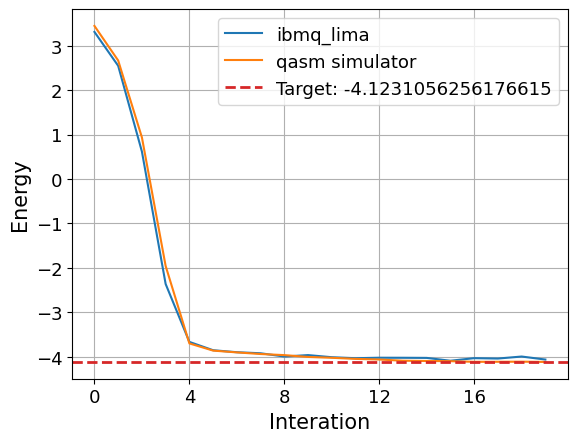

In [34]:
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gs_energy_2 = -4.1231056256176615
plt.plot(data_energy_2, label='ibmq_lima')
plt.plot(data_energy_simulator_2, label='qasm simulator')
plt.axhline(y=gs_energy_2, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_2))
plt.legend(fontsize=13)
plt.xlabel('Interation', fontsize=15)
plt.ylabel('Energy', fontsize=15)
size_tick = 13
plt.yticks(fontsize=size_tick)
plt.xticks([i for i in range(0,20, 4)], fontsize=size_tick)
plt.grid()
fig.savefig('PRS-2-h2-ibmq_lima.png', format='png', dpi=200)

h = 1.5

In [5]:
data_energy_15 = np.array([2.5814453719668, 2.188839907739143, 1.4772505188254692, 0.2040293223732439, -1.5404188150896467, -2.5848581584493524, -2.848483621860191, -2.8609321713113682, -2.8855237349105223, -2.9274993815232797, -2.9153143317221284, -2.92963817111631, -3.0169026437194932, -2.9928340524619528, -3.0446448715059886, -3.0201379626535814, -3.029465977524639, -3.0777711747740666, -3.0541131907999817, -3.0978272061437364])
data_params_15 = np.array([[0.5, 0.5, 0.5, 0.5], [0.47750251, 0.33526754, 0.31219505, 0.46116529], [0.47872126, 0.10696714 ,0.06497219 ,0.37494861], [ 0.51526536, -0.23521458 ,-0.23153202  ,0.21592389], [ 0.59938041, -0.67937679, -0.55062113, -0.02528724], [ 0.63409096, -1.10340892, -0.78663753, -0.23171114], [ 0.597547,   -1.34164683, -0.86804725, -0.2833739 ], [ 0.54100007, -1.4526565 , -0.8896024 , -0.25354504], [ 0.51322274, -1.52545906, -0.90125882, -0.20443049], [ 0.49998511, -1.57543595, -0.91665759, -0.16153832], [ 0.50221327, -1.61858716, -0.93424255, -0.11225614], [ 0.50577948, -1.65875529, -0.95177558, -0.06395397], [ 0.51783811, -1.6871906 , -0.9610851 , -0.0158418 ], [ 0.53373399, -1.74708455, -0.95899247 , 0.01163501], [ 0.54524564, -1.79843866, -0.9509595 ,  0.04692622], [ 0.56639212, -1.8377826 , -0.93729295,  0.08485233], [ 0.58756408, -1.87026264, -0.93158159 , 0.12196057], [ 0.6082503 , -1.89717995 ,-0.92102364,  0.16132115], [ 0.63124141 ,-1.92392205 ,-0.91505448,  0.18986587], [ 0.64551486, -1.9442956,  -0.89885741, 0.22018651]])

data_energy_simulator_15 = np.array([2.74535, 2.410275, 1.8353750000000002, 0.7648250000000001, -0.8930749999999998, -2.37535, -2.8169250000000003, -2.9063, -2.9290249999999998, -2.950525, -2.96495, -2.987125, -2.9986249999999997, -3.0153, -3.035375, -3.0437, -3.0677250000000003, -3.0688749999999994, -3.08995, -3.1055])

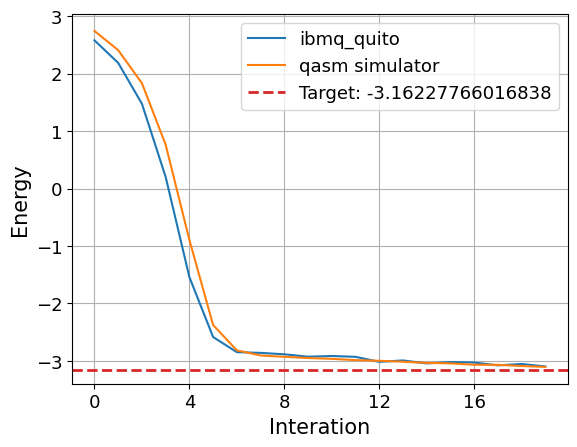

In [42]:
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gs_energy_15 = -3.16227766016838
plt.plot(data_energy_15, label='ibmq_quito')
plt.plot(data_energy_simulator_15, label='qasm simulator')
plt.axhline(y=gs_energy_15, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_15))
plt.legend(fontsize=13)
plt.xlabel('Interation', fontsize=15)
plt.ylabel('Energy', fontsize=15)
size_tick = 13
plt.yticks(fontsize=size_tick)
plt.xticks([i for i in range(0,20, 4)], fontsize=size_tick)
plt.grid()
fig.savefig('PRS-2-h15-ibmq_quito.png', format='png', dpi=200)

h = 1.0

In [3]:
import numpy as np
data_energy_1 = np.array([1.9953664023842184, 1.8834851316519523, 1.734640483867674, 1.4807290545181337, 1.2027892225247503, 0.8581020486648094, 0.4442741892207769, 0.01634681991508055, -0.46949571229948406, -0.9284605594736546, -1.2841552587306628, -1.494465214435656, -1.6393526135895569, -1.7114409716550179, -1.7929818326654412, -1.7977881441408463, -1.8805104407090882, -1.9134837253328127, -1.9293837716075004, -1.931689713756229])
data_params_1 = np.array([[0.5, 0.5, 0.5, 0.5], [0.45647406, 0.43776782, 0.37661121, 0.51153672], [0.4129673,  0.3720893 , 0.22207661, 0.53350647], [0.36869055, 0.3068915,  0.03614314, 0.56368861], [ 0.33639947,  0.24110553 -0.18547151,  0.59559873], [ 0.32753168,  0.16993765, -0.43552578,  0.63074067], [ 0.34542478,  0.08536363, -0.70466956,  0.66022275], [ 0.40046503, -0.02389345, -0.9785417 ,  0.66510806], [ 0.47547872, -0.171286  , -1.23967049,  0.64314469], [ 0.55274325, -0.35376493, -1.46451231,  0.58851595], [ 0.6016456 , -0.54734305, -1.63920638,  0.51347552], [ 0.60641328, -0.72515182, -1.75467645,  0.43755881], [ 0.5732216 , -0.86996614, -1.82361993,  0.38438348], [ 0.51696881, -0.98963115, -1.85544107,  0.33989814], [ 0.45569176, -1.09474459, -1.87120262,  0.30776791], [ 0.38734136, -1.18179444, -1.87863974,  0.28303705], [ 0.32295148, -1.25155354, -1.87942447,  0.26938394], [ 0.260614,   -1.30803189, -1.87469614,  0.2534551 ], [ 0.20538899, -1.35271077, -1.86894228,  0.24401019], [ 0.15935242, -1.39468129, -1.86515012,  0.23271402] ])
data_energy_simulator_1 = np.array([2.0250500000000002, 1.92035, 1.7618500000000001, 1.55985, 1.2840500000000001, 0.96595, 0.61405, 0.2669499999999999, -0.03380000000000005, -0.31320000000000014, -0.5741999999999999, -0.8115, -1.0263499999999999, -1.2023, -1.3584, -1.4638499999999999, -1.5772, -1.65495, -1.7507, -1.8248000000000002])


C:\Users\DELL\AppData\Local\Temp\ipykernel_6612\1942136597.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_params_1 = np.array([[0.5, 0.5, 0.5, 0.5], [0.45647406, 0.43776782, 0.37661121, 0.51153672], [0.4129673,  0.3720893 , 0.22207661, 0.53350647], [0.36869055, 0.3068915,  0.03614314, 0.56368861], [ 0.33639947,  0.24110553 -0.18547151,  0.59559873], [ 0.32753168,  0.16993765, -0.43552578,  0.63074067], [ 0.34542478,  0.08536363, -0.70466956,  0.66022275], [ 0.40046503, -0.02389345, -0.9785417 ,  0.66510806], [ 0.47547872, -0.171286  , -1.23967049,  0.64314469], [ 0.55274325, -0.35376493, -1.46451231,  0.58851595], [ 0.6016456 , -0.54734305, -1.63920638,  0.51347552], [ 0.60641328, -0.72515182, -1.75467645,  0.43755881], [ 0.5732216 , -0.86996614, -1.82361993

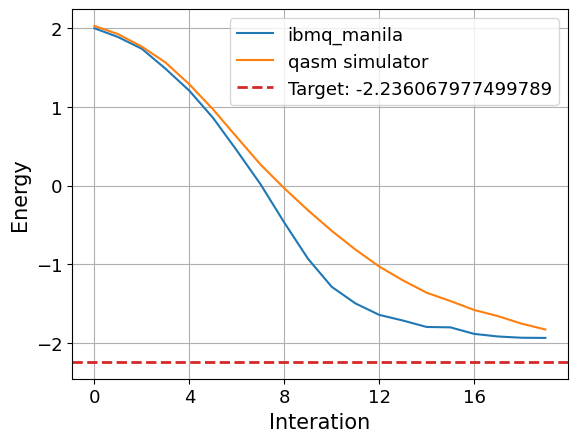

In [39]:
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gs_energy_1 = -2.236067977499789
plt.plot(data_energy_1, label='ibmq_manila')
plt.plot(data_energy_simulator_1, label='qasm simulator')
plt.axhline(y=gs_energy_1, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy_1))
plt.legend(fontsize=13)
plt.xlabel('Interation', fontsize=15)
plt.ylabel('Energy', fontsize=15)
size_tick = 13
plt.yticks(fontsize=size_tick)
plt.xticks([i for i in range(0,20, 4)], fontsize=size_tick)
plt.grid()
fig.savefig('PRS-2-h1-ibmq_manila.png', format='png', dpi=200)